## Example with HCV data

In [8]:
%load_ext nb_black
# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%config InlineBackend.figure_formats = ['svg']

from Bio import AlignIO
import numpy as np
import jax.numpy as jnp
import jax
from jax.scipy.special import xlogy

jax.config.update("jax_enable_x64", True)

from vbsky.fasta import SeqData
from vbsky.bdsky import _lognorm_logpdf
from vbsky.prob import VF
from vbsky.prob.transform import (
    Transform,
    Compose,
    Positive,
    ZeroOne,
    DiagonalAffine,
    Exp,
)
from vbsky.prob.distribution import Constant

from vbsky.plot import plot_helper, plot_one

pos = Compose(DiagonalAffine, Exp)
plus = Compose(DiagonalAffine, Positive)
z1 = Compose(DiagonalAffine, ZeroOne)

<IPython.core.display.Javascript object>

#### Import Data

In [2]:
hcv = AlignIO.read("HCV.nexus", format="nexus")
data = SeqData(hcv, gisaid=False, contemp=True, dates=1993.0)

<IPython.core.display.Javascript object>

#### Data Preprocessing

In [3]:
n_tips = 10 #Number of tips per tree
n_trees = 10 #Number of trees
temp_folder = "./" #Place to save temporary folders
tree_path = "./subsample.trees"

data.prep_data(
    n_tips,
    n_trees,
    temp_folder,
    tree_path,
)

Readying trees


100%|██████████| 10/10 [00:00<00:00, 51.55it/s]


Writing phylo trees
Processing trees


100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Readying tip data


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


<IPython.core.display.Javascript object>

#### Define Priors and Parameters

In [4]:
#Define a function to give value of prior given parameters
def _params_prior_loglik(params):
    ll = 0
    tau = {"R": params["precision_R"][0], "delta": params["precision_delta"][0]}
    ll += jax.scipy.stats.gamma.logpdf(tau["R"], a=0.001, scale=1 / 0.001)
    ll += jax.scipy.stats.gamma.logpdf(tau["delta"], a=0.001, scale=1 / 0.001)
    ll += jax.scipy.stats.beta.logpdf(params["rho_m"], 1, 9999).sum()

    mus = [1.0, 1.0, 1.0]
    sigmas = [1.25, 1.25, 1.25]

    for i, k in enumerate(["R", "delta", "origin"]):
        log_rate = jnp.log(params[k])
        ll += _lognorm_logpdf(log_rate, mu=mus[i], sigma=sigmas[i]).sum()

    for k in ["R", "delta"]:
        log_rate = jnp.log(params[k])
        ll -= (tau[k] / 2) * (jnp.diff(log_rate) ** 2).sum()
        m = len(log_rate)
        ll += xlogy((m - 1) / 2, tau[k] / (2 * jnp.pi))

    return ll


m = 10 #Number of intervals 

# Define local parameters for the different trees in our ensemble
local_flows = [
    {"proportions": Transform(td.n - 2, z1), "root_proportion": Transform(1, z1)}
    for td in data.tds
]

# Define global epidemiological parameters
global_flows = VF(
    origin=Transform(1, pos),
    origin_start=Constant(0.0),
    delta=Transform(m, pos),
    R=Transform(m, pos),
    rho_m=Transform(1, z1),
    s=Constant(np.repeat(0.00, m)),
    precision_R=Transform(1, pos),
    precision_delta=Transform(1, pos),
    clock_rate=Constant(0.79e-3),
)

data.setup_flows(global_flows, local_flows)

<IPython.core.display.Javascript object>

#### Run Optimization Loop

In [5]:
rng = jax.random.PRNGKey(6)
n_iter = 10
threshold = 0.001
step_size = 1.0

res = data.loop(
    _params_prior_loglik, rng, n_iter, step_size=step_size, threshold=threshold,
)

100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


<IPython.core.display.Javascript object>

#### Visualize Posteriors

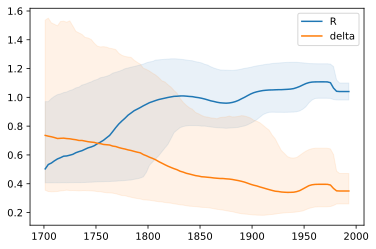

<IPython.core.display.Javascript object>

In [6]:
fig, ax = plt.subplots()
start, top, end, x0 = plot_helper(res, data, n_tips)
plot_one(res, ax, "R", m, start, top, end, x0, "R", "fill", "")
plot_one(res, ax, "delta", m, start, top, end, x0, "delta", "fill", "")
ax.legend()